<a href="https://colab.research.google.com/github/adeepH/SPDRA-2021-SharedTask/blob/main/Notebooks/spdra2021_roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/sdpra2021/train.csv',delimiter=',',
                 header=None,names=['text','label'])

train.label = train.label.apply({'CL':0,'CR':1,'DC':2,
'DS':3,'LO':4, 'NI':5, 'SE':6}.get)
val = pd.read_csv('/content/drive/MyDrive/sdpra2021/validation.csv',delimiter=',',
                 header=None,names=['text','label'])

val.label = val.label.apply({'CL':0,'CR':1,'DC':2,
'DS':3,'LO':4, 'NI':5, 'SE':6}.get)

test = pd.read_csv('/content/drive/MyDrive/sdpra2021/test.csv',delimiter=',',
                 header=None,names=['text'])

In [4]:

print('Training set size:',train.shape)
print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16800, 2)
Testing set size: (7000, 1)
validation set size: (11200, 2)


In [6]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [7]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.label.values),
                                                  train.label.values)
class_weights

array([0.87591241, 0.90225564, 1.17531832, 0.87687249, 1.32523468,
       0.8683068 , 1.17302053])

In [8]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [9]:
from transformers import *
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [11]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [12]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.5)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.5)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [13]:
import torch.nn as nn
from transformers import BertModel,BertTokenizer
class MixedBertModel(nn.Module):
    def __init__(self,pre_trained='bert-base-uncased'):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(pre_trained)
        self.hidden_size = self.bert.config.hidden_size
        self.LSTM = nn.LSTM(self.hidden_size,self.hidden_size,bidirectional=True)
        self.clf = nn.Linear(self.hidden_size*2,1)
        
    def forward(self,inputs):
        
        encoded_layers, pooled_output = self.bert(input_ids=inputs[0],attention_mask=inputs[1])
        encoded_layers = encoded_layers.permute(1, 0, 2)
        enc_hiddens, (last_hidden, last_cell) = self.LSTM(pack_padded_sequence(encoded_layers, inputs[2]))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        output_hidden = F.dropout(output_hidden,0.2)
        output = self.clf(output_hidden)
        
        return F.softmax(output)

In [14]:
model = RFClassifier(7,'roberta-base')
#model = MixedBertModel()
model = model.to(device)

In [15]:

EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
    start_time = time.time()
    train_acc,train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train)
    )


    val_acc,val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val)
    )

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss {train_loss} accuracy {train_acc}')
    print(f'Val Loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc

torch.save(model.state_dict(),'roberta.bin')

Epoch: 01 | Epoch Time: 7m 57s
Train Loss 0.7176843663624355 accuracy 0.7930357142857143
Val Loss 0.4078649086824485 accuracy 0.8794642857142857

Epoch: 02 | Epoch Time: 8m 2s
Train Loss 0.37307277222474416 accuracy 0.8989880952380952
Val Loss 0.37911972799471444 accuracy 0.8891964285714286

Epoch: 03 | Epoch Time: 8m 2s
Train Loss 0.2826746159437157 accuracy 0.9260714285714285
Val Loss 0.3536724283280117 accuracy 0.8970535714285715

Epoch: 04 | Epoch Time: 8m 2s
Train Loss 0.21471713477656953 accuracy 0.9457738095238095
Val Loss 0.38223717155467185 accuracy 0.8975

Epoch: 05 | Epoch Time: 8m 1s
Train Loss 0.1750098448601507 accuracy 0.959047619047619
Val Loss 0.4000653393233993 accuracy 0.8960714285714285



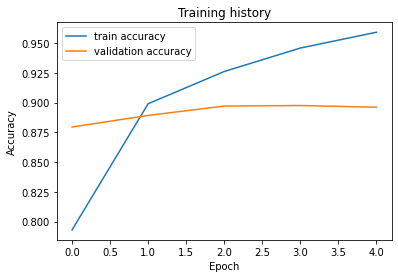

In [20]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [21]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.8960714285714285

In [22]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [23]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [24]:
class_name = ['CL' ,'CR' ,'DC' ,
'DS' ,'LO' , 'NI' , 'SE' ]

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

              precision    recall  f1-score   support

          CL       0.97      0.98      0.97      1866
          CR       0.90      0.88      0.89      1835
          DC       0.80      0.79      0.79      1355
          DS       0.90      0.91      0.91      1774
          LO       0.90      0.89      0.90      1217
          NI       0.89      0.89      0.89      1826
          SE       0.87      0.90      0.88      1327

    accuracy                           0.90     11200
   macro avg       0.89      0.89      0.89     11200
weighted avg       0.90      0.90      0.90     11200



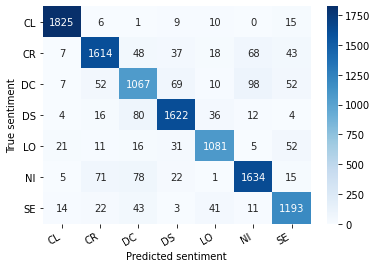

In [26]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [29]:
from google.colab import files
files.download('roberta.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inference**

In [30]:
#the_model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load('/content/spdra_bert-base-uncased.bin'))
Model = RFClassifier(7,'roberta-base')
Model.load_state_dict(torch.load('roberta.bin'))
Model.to(device)
for param in model.parameters():
    param.requires_grad = False
Model.eval()

RFClassifier(
  (auto): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  Model,
  val_data_loader
)

In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

              precision    recall  f1-score   support

          CL       0.97      0.98      0.97      1866
          CR       0.90      0.88      0.89      1835
          DC       0.80      0.79      0.79      1355
          DS       0.90      0.91      0.91      1774
          LO       0.90      0.89      0.90      1217
          NI       0.89      0.89      0.89      1826
          SE       0.87      0.90      0.88      1327

    accuracy                           0.90     11200
   macro avg       0.89      0.89      0.89     11200
weighted avg       0.90      0.90      0.90     11200



In [33]:
spdra_roBERTa_preds = pd.DataFrame(list(zip(y_review_texts,y_test.tolist(),y_pred.tolist())),
                          columns = ['text','true_labels','pred_labels'])
spdra_roBERTa_preds.head(4)
spdra_roBERTa_preds.to_csv('spdra_roBERTa_preds.csv')

In [35]:
files.download('spdra_roBERTa_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>